In [1]:
import keras
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import LearningRateScheduler
import numpy as np
import tensorflow as tf
!pip install tensorflow==1.14.0

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [175]:
from keras.datasets import boston_housing

(x_train, y_train), (x_test, y_test) = boston_housing.load_data()


In [176]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(8, activation='relu', input_shape=(train_data.shape[1],)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1))


In [177]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_54 (Dense)             (None, 8)                 112       
_________________________________________________________________
dense_55 (Dense)             (None, 16)                144       
_________________________________________________________________
dense_56 (Dense)             (None, 1)                 17        
Total params: 273
Trainable params: 273
Non-trainable params: 0
_________________________________________________________________


In [178]:
from keras import backend as K
func = K.function([model.layers[0].input], [model.layers[-2].output])

In [179]:
model.layers[-2].output

<tf.Tensor 'dense_55/Relu:0' shape=(?, 16) dtype=float32>

In [180]:
lrs = []
K2 = 0.
beta2 = 0.9
batch_size=32
num_classes=2
from tqdm import tqdm

In [181]:
def lr_schedule(epoch):
    global K2

    Kz = 0.  # max penultimate activation
    S = 0.
    
    sess = K.get_session()
    max_wt = 0.
    for weight in model.weights:
        norm = np.linalg.norm(weight.eval(sess))
        if norm > max_wt:
            max_wt = norm
    
    for i in tqdm(range((len(x_train) - 1) // batch_size + 1)):
        start_i = i * batch_size
        end_i = start_i + batch_size
        xb = x_train[start_i:end_i]
    	
        tmp = np.array(func([xb]))
        activ = np.linalg.norm(tmp)
        sq = np.linalg.norm(np.square(tmp))

        if sq > S:
            S = sq
        
        if activ > Kz:
            Kz = activ

    S_ = (num_classes - 1) ** 2 / (num_classes * batch_size) ** 2 * S + 2e-4 * max_wt * ((num_classes - 1) * Kz) / (num_classes * batch_size)
    
    K2 = beta2 * K2 + (1 - beta2) * S_

    lr = (np.sqrt(K2) + K.epsilon()) / Kz
    print('S =', S, 'max_wt =', max_wt, 'Kz =', Kz, 'K2 =', K2, 'S_ =', S_)
    lrs.append(lr)
    print('Epoch', epoch+1, 'LR =', lr)
    return lr

In [182]:
lr_scheduler = LearningRateScheduler(lr_schedule)

In [183]:
from keras.optimizers import RMSprop
optimizer = RMSprop(lr=1e-3, decay=1e-4)
model.compile(loss='mse', optimizer=optimizer, metrics=["mae"])

In [184]:
history=model.fit(train_data, train_targets, epochs = 200, batch_size = 32,validation_data=(test_data,test_targets),callbacks=[lr_scheduler])

Train on 404 samples, validate on 102 samples
Epoch 1/200


100%|██████████| 13/13 [00:00<00:00, 167.23it/s]


S = 137189.08 max_wt = 3.4273033 Kz = 1006.41583 K2 = 3.35042063151059 S_ = 33.50420631510591
Epoch 1 LR = 0.0018187467513853426
404/404 [==============================] - 1s 2ms/step - loss: 4991.3161 - mae: 48.9645 - val_loss: 2460.1653 - val_mae: 36.0196


100%|██████████| 13/13 [00:00<00:00, 1754.15it/s]

Epoch 2/200
S = 101230.6 max_wt = 3.4177365 Kz = 833.5752 K2 = 5.4877190956926825 S_ = 24.723405273331522
Epoch 2 LR = 0.002810290220080116
404/404 [==============================] - 0s 83us/step - loss: 1144.8574 - mae: 24.3775 - val_loss: 647.5663 - val_mae: 19.9590



100%|██████████| 13/13 [00:00<00:00, 1772.11it/s]

Epoch 3/200
S = 105972.91 max_wt = 3.4301026 Kz = 847.8283 K2 = 7.527085135765288 S_ = 25.88137949641875
Epoch 3 LR = 0.0032359776754036468
404/404 [==============================] - 0s 80us/step - loss: 370.8539 - mae: 14.9883 - val_loss: 343.6846 - val_mae: 15.3544



100%|██████████| 13/13 [00:00<00:00, 1751.89it/s]

Epoch 4/200
S = 117842.45 max_wt = 3.4334915 Kz = 888.5094 K2 = 9.652342978386613 S_ = 28.77966356197854
Epoch 4 LR = 0.0034966676866642924
404/404 [==============================] - 0s 80us/step - loss: 236.7988 - mae: 12.4745 - val_loss: 228.2058 - val_mae: 12.1167



100%|██████████| 13/13 [00:00<00:00, 1725.78it/s]

Epoch 5/200
S = 130564.92 max_wt = 3.4340918 Kz = 933.56573 K2 = 11.875730703024582 S_ = 31.886220224766298
Epoch 5 LR = 0.0036913504633226206
404/404 [==============================] - 0s 80us/step - loss: 161.9735 - mae: 9.8289 - val_loss: 143.1565 - val_mae: 8.8661



100%|██████████| 13/13 [00:00<00:00, 1595.17it/s]

Epoch 6/200
S = 147010.69 max_wt = 3.4365475 Kz = 997.03516 K2 = 14.278356482606139 S_ = 35.90198849884015
Epoch 6 LR = 0.0037899078434521986
404/404 [==============================] - 0s 81us/step - loss: 108.3980 - mae: 7.5020 - val_loss: 125.2078 - val_mae: 8.2134



100%|██████████| 13/13 [00:00<00:00, 1714.54it/s]

Epoch 7/200
S = 168273.31 max_wt = 3.440573 Kz = 1072.1327 K2 = 16.959908737415844 S_ = 41.09387903070319
Epoch 7 LR = 0.003841167341397056
 32/404 [=>............................] - ETA: 0s - loss: 106.9381 - mae: 7.3952

404/404 [==============================] - 0s 87us/step - loss: 98.3379 - mae: 7.0302 - val_loss: 142.3956 - val_mae: 10.0537


100%|██████████| 13/13 [00:00<00:00, 1675.76it/s]

Epoch 8/200
S = 169950.53 max_wt = 3.436455 Kz = 1093.6029 K2 = 19.414275167140048 S_ = 41.50357303465788
Epoch 8 LR = 0.004029034117172752
 32/404 [=>............................] - ETA: 0s - loss: 113.8631 - mae: 8.5695

404/404 [==============================] - 0s 80us/step - loss: 97.4901 - mae: 7.1427 - val_loss: 80.5276 - val_mae: 6.6064


100%|██████████| 13/13 [00:00<00:00, 1729.61it/s]

Epoch 9/200
S = 176644.3 max_wt = 3.4386015 Kz = 1115.2018 K2 = 21.78665090913656 S_ = 43.13803258710521
Epoch 9 LR = 0.004185446469763824
 32/404 [=>............................] - ETA: 0s - loss: 53.7969 - mae: 5.2261

404/404 [==============================] - 0s 101us/step - loss: 82.8160 - mae: 6.4373 - val_loss: 78.8528 - val_mae: 6.4141


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 10/200


100%|██████████| 13/13 [00:00<00:00, 1307.11it/s]

S = 179542.25 max_wt = 3.438259 Kz = 1131.0247 K2 = 23.992556767232823 S_ = 43.84570949009917
Epoch 10 LR = 0.004330780783043023
 32/404 [=>............................] - ETA: 0s - loss: 54.3322 - mae: 5.0722

404/404 [==============================] - 0s 96us/step - loss: 84.9025 - mae: 6.6276 - val_loss: 106.6042 - val_mae: 7.6809
Epoch 11/200


100%|██████████| 13/13 [00:00<00:00, 1673.24it/s]

S = 178796.14 max_wt = 3.4409733 Kz = 1148.134 K2 = 25.959675835778405 S_ = 43.66374745268866
Epoch 11 LR = 0.004437690916131232
 32/404 [=>............................] - ETA: 0s - loss: 100.5710 - mae: 6.5292

404/404 [==============================] - 0s 90us/step - loss: 87.9846 - mae: 6.5334 - val_loss: 74.2494 - val_mae: 6.2843
Epoch 12/200


100%|██████████| 13/13 [00:00<00:00, 1650.05it/s]

S = 179470.47 max_wt = 3.4384346 Kz = 1162.1442 K2 = 27.746560229638682 S_ = 43.828519774381164
Epoch 12 LR = 0.004532570602010432
404/404 [==============================] - 0s 98us/step - loss: 75.0984 - mae: 6.0062 - val_loss: 65.2704 - val_mae: 6.0871



100%|██████████| 13/13 [00:00<00:00, 1590.84it/s]

Epoch 13/200
S = 182070.94 max_wt = 3.4341133 Kz = 1187.1632 K2 = 29.418269470770674 S_ = 44.4636526409586
Epoch 13 LR = 0.004568757846787018
 32/404 [=>............................] - ETA: 0s - loss: 37.3027 - mae: 4.8610

404/404 [==============================] - 0s 96us/step - loss: 66.3858 - mae: 5.7342 - val_loss: 97.0691 - val_mae: 8.2527


100%|██████████| 13/13 [00:00<00:00, 1643.93it/s]

Epoch 14/200
S = 182160.95 max_wt = 3.4344463 Kz = 1204.6 K2 = 30.925024272712893 S_ = 44.485817490192886
Epoch 14 LR = 0.004616493010511532
404/404 [==============================] - 0s 84us/step - loss: 70.7347 - mae: 6.1462 - val_loss: 122.7517 - val_mae: 9.8319



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 15/200


100%|██████████| 13/13 [00:00<00:00, 1349.89it/s]

S = 178298.33 max_wt = 3.4328506 Kz = 1198.0656 K2 = 32.186793615695656 S_ = 43.542717702540514
Epoch 15 LR = 0.0047354176040422455
404/404 [==============================] - 0s 92us/step - loss: 84.0321 - mae: 6.7302 - val_loss: 106.2592 - val_mae: 7.7408



100%|██████████| 13/13 [00:00<00:00, 1437.28it/s]

Epoch 16/200
S = 176467.22 max_wt = 3.4358265 Kz = 1193.9696 K2 = 33.27767792203197 S_ = 43.09563667905878
Epoch 16 LR = 0.004831514015603876
404/404 [==============================] - 0s 92us/step - loss: 64.1460 - mae: 5.5626 - val_loss: 62.0216 - val_mae: 5.5932



100%|██████████| 13/13 [00:00<00:00, 1681.91it/s]


Epoch 17/200
S = 178155.08 max_wt = 3.4314544 Kz = 1198.6493 K2 = 34.30068468886839 S_ = 43.507745590396155
Epoch 17 LR = 0.0048860653227257664
404/404 [==============================] - 0s 91us/step - loss: 70.4090 - mae: 5.9745 - val_loss: 56.2558 - val_mae: 5.6988


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 18/200


100%|██████████| 13/13 [00:00<00:00, 1406.18it/s]


S = 174591.75 max_wt = 3.4309032 Kz = 1182.4868 K2 = 35.13437792827781 S_ = 42.6376170829626
Epoch 18 LR = 0.005012678305231165
404/404 [==============================] - 0s 88us/step - loss: 68.4821 - mae: 5.8606 - val_loss: 92.7581 - val_mae: 7.0951
Epoch 19/200


100%|██████████| 13/13 [00:00<00:00, 1685.24it/s]


S = 170728.7 max_wt = 3.432666 Kz = 1173.2206 K2 = 35.79037988736065 S_ = 41.69439751910621
Epoch 19 LR = 0.005099216934138506
404/404 [==============================] - 0s 87us/step - loss: 66.8280 - mae: 5.8518 - val_loss: 51.9180 - val_mae: 5.2070


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 20/200


100%|██████████| 13/13 [00:00<00:00, 1448.77it/s]

S = 167727.66 max_wt = 3.4314938 Kz = 1156.7367 K2 = 36.30749579839923 S_ = 40.9615389977464
Epoch 20 LR = 0.005209111367578385
 32/404 [=>............................] - ETA: 0s - loss: 74.8211 - mae: 5.5815

404/404 [==============================] - 0s 87us/step - loss: 73.1464 - mae: 6.2087 - val_loss: 57.1834 - val_mae: 5.8100
Epoch 21/200


100%|██████████| 13/13 [00:00<00:00, 1606.73it/s]

S = 163559.1 max_wt = 3.429754 Kz = 1145.9468 K2 = 36.6711163794292 S_ = 39.94370160869893
Epoch 21 LR = 0.0052844236222069066
 32/404 [=>............................] - ETA: 0s - loss: 74.1647 - mae: 6.6878

404/404 [==============================] - 0s 91us/step - loss: 57.1108 - mae: 5.2395 - val_loss: 67.0172 - val_mae: 6.8294
Epoch 22/200


100%|██████████| 13/13 [00:00<00:00, 1744.33it/s]

S = 164709.66 max_wt = 3.427429 Kz = 1146.8456 K2 = 37.026464937201695 S_ = 40.224601957154135
Epoch 22 LR = 0.005305803803402403
 32/404 [=>............................] - ETA: 0s - loss: 61.9497 - mae: 6.2714

404/404 [==============================] - 0s 89us/step - loss: 67.7323 - mae: 5.9135 - val_loss: 110.8749 - val_mae: 9.1800


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 23/200


100%|██████████| 13/13 [00:00<00:00, 1380.61it/s]

S = 156216.19 max_wt = 3.4268339 Kz = 1122.1837 K2 = 37.13889193898184 S_ = 38.15073495500319
Epoch 23 LR = 0.005430633769907665
 32/404 [=>............................] - ETA: 0s - loss: 94.4796 - mae: 8.7357

404/404 [==============================] - 0s 90us/step - loss: 78.1329 - mae: 6.4055 - val_loss: 64.5987 - val_mae: 6.4184
Epoch 24/200


100%|██████████| 13/13 [00:00<00:00, 1652.05it/s]


S = 155887.14 max_wt = 3.426828 Kz = 1114.5016 K2 = 37.23203464085528 S_ = 38.070318957716204
Epoch 24 LR = 0.005474919033265003
404/404 [==============================] - 0s 93us/step - loss: 58.4516 - mae: 5.5334 - val_loss: 143.5775 - val_mae: 10.1775


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 25/200


100%|██████████| 13/13 [00:00<00:00, 1504.16it/s]


S = 151709.56 max_wt = 3.4250307 Kz = 1103.3832 K2 = 37.21385889288932 S_ = 37.05027716119569
Epoch 25 LR = 0.00552873789649626
404/404 [==============================] - 0s 98us/step - loss: 66.9044 - mae: 5.8436 - val_loss: 48.0282 - val_mae: 4.7901


100%|██████████| 13/13 [00:00<00:00, 1655.51it/s]


Epoch 26/200
S = 150739.86 max_wt = 3.428315 Kz = 1096.2634 K2 = 37.173819831707284 S_ = 36.813468281068985
Epoch 26 LR = 0.005561650272149573
404/404 [==============================] - 0s 91us/step - loss: 60.9661 - mae: 6.0357 - val_loss: 60.7943 - val_mae: 5.5992


100%|██████████| 13/13 [00:00<00:00, 1734.73it/s]


Epoch 27/200
S = 150287.1 max_wt = 3.4296544 Kz = 1092.3291 K2 = 37.12672707056289 S_ = 36.70289222026337
Epoch 27 LR = 0.0055781454675518155
404/404 [==============================] - 0s 85us/step - loss: 62.4276 - mae: 5.7770 - val_loss: 81.8428 - val_mae: 6.6160
Epoch 28/200


100%|██████████| 13/13 [00:00<00:00, 1638.45it/s]

S = 138435.3 max_wt = 3.429599 Kz = 1067.4235 K2 = 36.79496636439623 S_ = 33.809120008896215
Epoch 28 LR = 0.0056827358329255544
404/404 [==============================] - 0s 94us/step - loss: 54.1655 - mae: 5.6114 - val_loss: 135.5008 - val_mae: 10.2564
Epoch 29/200



100%|██████████| 13/13 [00:00<00:00, 1778.17it/s]

S = 141472.67 max_wt = 3.4266257 Kz = 1069.7963 K2 = 36.570537940968855 S_ = 34.55068213012246
Epoch 29 LR = 0.005652812811607681
404/404 [==============================] - 0s 87us/step - loss: 67.9895 - mae: 6.2117 - val_loss: 46.1657 - val_mae: 4.7457
Epoch 30/200



100%|██████████| 13/13 [00:00<00:00, 1622.41it/s]


S = 137013.66 max_wt = 3.427475 Kz = 1050.7426 K2 = 36.25966954947818 S_ = 33.46185402606212
Epoch 30 LR = 0.0057308046837571125
404/404 [==============================] - 0s 91us/step - loss: 54.5120 - mae: 5.6555 - val_loss: 51.2000 - val_mae: 5.5063
Epoch 31/200


100%|██████████| 13/13 [00:00<00:00, 1652.80it/s]


S = 137051.7 max_wt = 3.428531 Kz = 1048.2323 K2 = 35.980814533125326 S_ = 33.471119385949606
Epoch 31 LR = 0.005722396742729791
404/404 [==============================] - 0s 90us/step - loss: 74.0088 - mae: 6.5808 - val_loss: 50.8217 - val_mae: 5.0137
Epoch 32/200


100%|██████████| 13/13 [00:00<00:00, 1645.22it/s]


S = 127112.36 max_wt = 3.4260244 Kz = 1026.6478 K2 = 35.48716132878649 S_ = 31.04428248973696
Epoch 32 LR = 0.005802486589456232
404/404 [==============================] - 0s 90us/step - loss: 60.3323 - mae: 5.5448 - val_loss: 60.4708 - val_mae: 6.7089
Epoch 33/200


100%|██████████| 13/13 [00:00<00:00, 1660.86it/s]

S = 124464.32 max_wt = 3.4409456 Kz = 1015.33167 K2 = 34.97821667261569 S_ = 30.397714767078476
Epoch 33 LR = 0.005824932653061519
 32/404 [=>............................] - ETA: 0s - loss: 72.0185 - mae: 7.0613

404/404 [==============================] - 0s 95us/step - loss: 42.7992 - mae: 4.7789 - val_loss: 203.6261 - val_mae: 12.6127
Epoch 34/200


100%|██████████| 13/13 [00:00<00:00, 1473.63it/s]

S = 132107.52 max_wt = 3.4696426 Kz = 1040.1012 K2 = 34.706803892123745 S_ = 32.26408886769629
Epoch 34 LR = 0.005664110566305494
 32/404 [=>............................] - ETA: 0s - loss: 285.8619 - mae: 13.9657

404/404 [==============================] - 0s 99us/step - loss: 71.7449 - mae: 5.9340 - val_loss: 39.5632 - val_mae: 4.3541
Epoch 35/200


100%|██████████| 13/13 [00:00<00:00, 1659.14it/s]

S = 124620.74 max_wt = 3.4894316 Kz = 1013.4461 K2 = 34.27972720112555 S_ = 30.43603698214178
Epoch 35 LR = 0.0057772083155486305
404/404 [==============================] - 0s 89us/step - loss: 58.8229 - mae: 5.7399 - val_loss: 56.3635 - val_mae: 5.3529
Epoch 36/200



100%|██████████| 13/13 [00:00<00:00, 1503.17it/s]


S = 121256.65 max_wt = 3.5256326 Kz = 1008.17004 K2 = 33.813232636129555 S_ = 29.614781551165578
Epoch 36 LR = 0.0057677916601096176
404/404 [==============================] - 0s 92us/step - loss: 48.2751 - mae: 4.9794 - val_loss: 162.4594 - val_mae: 11.2254
Epoch 37/200


100%|██████████| 13/13 [00:00<00:00, 1703.72it/s]


S = 118681.25 max_wt = 3.5496333 Kz = 999.1898 K2 = 33.33050918928857 S_ = 28.985998167719707
Epoch 37 LR = 0.005777939383433523
404/404 [==============================] - 0s 98us/step - loss: 63.2682 - mae: 6.0636 - val_loss: 62.7230 - val_mae: 6.1250


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 38/200


100%|██████████| 13/13 [00:00<00:00, 1504.04it/s]

S = 115758.125 max_wt = 3.5761657 Kz = 980.4824 K2 = 32.82468010886226 S_ = 28.272218385025454
Epoch 38 LR = 0.005843330445595939
404/404 [==============================] - 0s 86us/step - loss: 48.4531 - mae: 5.0222 - val_loss: 54.6921 - val_mae: 5.3987
Epoch 39/200



100%|██████████| 13/13 [00:00<00:00, 1598.81it/s]


S = 120129.05 max_wt = 3.6128757 Kz = 993.6166 K2 = 32.47617197306855 S_ = 29.339598750925216
Epoch 39 LR = 0.005735398459680093
404/404 [==============================] - 0s 95us/step - loss: 43.2190 - mae: 4.8788 - val_loss: 91.1094 - val_mae: 8.6506


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 40/200


100%|██████████| 13/13 [00:00<00:00, 1474.87it/s]


S = 114696.664 max_wt = 3.641017 Kz = 983.392 K2 = 32.029885221679876 S_ = 28.013304459181796
Epoch 40 LR = 0.0057550753642634815
404/404 [==============================] - 0s 92us/step - loss: 56.5493 - mae: 5.7601 - val_loss: 86.5323 - val_mae: 7.3301


100%|██████████| 13/13 [00:00<00:00, 1571.40it/s]


Epoch 41/200
S = 114890.42 max_wt = 3.6860812 Kz = 976.50073 K2 = 31.63296347137053 S_ = 28.06066771858643
Epoch 41 LR = 0.00575966698975489
404/404 [==============================] - 0s 92us/step - loss: 50.3377 - mae: 5.3015 - val_loss: 36.6068 - val_mae: 4.4398


100%|██████████| 13/13 [00:00<00:00, 1676.79it/s]


Epoch 42/200
S = 113941.07 max_wt = 3.7160003 Kz = 971.0098 K2 = 31.25255912141761 S_ = 27.828919971841326
Epoch 42 LR = 0.005757304179989717
404/404 [==============================] - 0s 83us/step - loss: 58.3593 - mae: 5.5814 - val_loss: 38.0430 - val_mae: 4.3480
Epoch 43/200


100%|██████████| 13/13 [00:00<00:00, 1608.20it/s]


S = 111666.51 max_wt = 3.753631 Kz = 962.66583 K2 = 30.854665526548917 S_ = 27.273623172730677
Epoch 43 LR = 0.005770120348389912
404/404 [==============================] - 0s 102us/step - loss: 56.3658 - mae: 5.6664 - val_loss: 44.0509 - val_mae: 5.1748


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 44/200


100%|██████████| 13/13 [00:00<00:00, 1535.64it/s]

S = 107453.18 max_wt = 3.7780318 Kz = 945.5237 K2 = 30.393683936908847 S_ = 26.24484963014822
Epoch 44 LR = 0.005830680826836406
404/404 [==============================] - 0s 95us/step - loss: 55.3067 - mae: 5.4023 - val_loss: 44.7460 - val_mae: 5.1333



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 45/200


100%|██████████| 13/13 [00:00<00:00, 1436.18it/s]

S = 102633.13 max_wt = 3.8128073 Kz = 928.90247 K2 = 29.861114051686474 S_ = 25.067985084685144
Epoch 45 LR = 0.005882783902203766
404/404 [==============================] - 0s 87us/step - loss: 48.7098 - mae: 5.3598 - val_loss: 104.8403 - val_mae: 8.5437



100%|██████████| 13/13 [00:00<00:00, 1682.07it/s]

Epoch 46/200
S = 108741.54 max_wt = 3.8348227 Kz = 942.1375 K2 = 29.530954418247042 S_ = 26.559517717292156
Epoch 46 LR = 0.005767989399889014
404/404 [==============================] - 0s 90us/step - loss: 44.0446 - mae: 5.0319 - val_loss: 33.6559 - val_mae: 4.2191
Epoch 47/200



100%|██████████| 13/13 [00:00<00:00, 1695.14it/s]

S = 106044.32 max_wt = 3.864172 Kz = 934.3611 K2 = 29.16795993152724 S_ = 25.901009551049032
Epoch 47 LR = 0.005780139148535568
404/404 [==============================] - 0s 97us/step - loss: 58.7414 - mae: 5.8702 - val_loss: 144.3893 - val_mae: 10.5071



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 48/200


100%|██████████| 13/13 [00:00<00:00, 1260.10it/s]

S = 104480.85 max_wt = 3.8924527 Kz = 926.45056 K2 = 28.80309290503874 S_ = 25.51928966664225
Epoch 48 LR = 0.005792917210661727
404/404 [==============================] - 0s 93us/step - loss: 40.8268 - mae: 4.5681 - val_loss: 35.0332 - val_mae: 4.5070
Epoch 49/200



100%|██████████| 13/13 [00:00<00:00, 1718.71it/s]


S = 103607.414 max_wt = 3.9174674 Kz = 921.8734 K2 = 28.453390062233204 S_ = 25.30606447698341
Epoch 49 LR = 0.005786230455673565
404/404 [==============================] - 0s 93us/step - loss: 54.3358 - mae: 5.5373 - val_loss: 93.9705 - val_mae: 7.9161
Epoch 50/200


100%|██████████| 13/13 [00:00<00:00, 1662.73it/s]

S = 107750.836 max_wt = 3.9494708 Kz = 925.2188 K2 = 28.23982861296505 S_ = 26.31777556955165
Epoch 50 LR = 0.005743631682838541
 32/404 [=>............................] - ETA: 0s - loss: 59.1487 - mae: 6.4580

404/404 [==============================] - 0s 97us/step - loss: 50.1408 - mae: 5.5129 - val_loss: 38.2319 - val_mae: 4.4119
Epoch 51/200


100%|██████████| 13/13 [00:00<00:00, 1602.29it/s]

S = 103513.25 max_wt = 3.9673202 Kz = 910.1352 K2 = 27.94415308104006 S_ = 25.283073293715155
Epoch 51 LR = 0.005808173435966396
404/404 [==============================] - 0s 83us/step - loss: 50.6074 - mae: 5.2907 - val_loss: 55.4062 - val_mae: 5.4306
Epoch 52/200


100%|██████████| 13/13 [00:00<00:00, 1547.85it/s]



S = 103739.72 max_wt = 3.994927 Kz = 909.105 K2 = 27.683580690221035 S_ = 25.338429172849825
Epoch 52 LR = 0.0057875812703330155
404/404 [==============================] - 0s 93us/step - loss: 48.1738 - mae: 5.3149 - val_loss: 43.1278 - val_mae: 4.8431
Epoch 53/200


100%|██████████| 13/13 [00:00<00:00, 1652.05it/s]


S = 93206.336 max_wt = 4.0335846 Kz = 882.3979 K2 = 27.191880190463113 S_ = 22.766575692641826
Epoch 53 LR = 0.005909560284179129
404/404 [==============================] - 0s 89us/step - loss: 43.5657 - mae: 4.9690 - val_loss: 33.6576 - val_mae: 4.2085
Epoch 54/200


100%|██████████| 13/13 [00:00<00:00, 1705.69it/s]


S = 99394.65 max_wt = 4.061152 Kz = 900.9493 K2 = 26.900462734270672 S_ = 24.27770562853871
Epoch 54 LR = 0.005756778785941613
404/404 [==============================] - 0s 92us/step - loss: 52.2602 - mae: 5.4764 - val_loss: 45.4626 - val_mae: 4.8940


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 55/200


100%|██████████| 13/13 [00:00<00:00, 1474.83it/s]


S = 100555.14 max_wt = 4.0971684 Kz = 896.84235 K2 = 26.666524234434107 S_ = 24.56107773590502
Epoch 55 LR = 0.005757939648939241
404/404 [==============================] - 0s 86us/step - loss: 33.8669 - mae: 4.1757 - val_loss: 63.8627 - val_mae: 7.0009
Epoch 56/200


100%|██████████| 13/13 [00:00<00:00, 1479.95it/s]

S = 96995.46 max_wt = 4.1291103 Kz = 891.0911 K2 = 26.369074873277896 S_ = 23.692030622871968
Epoch 56 LR = 0.00576269104859087
 32/404 [=>............................] - ETA: 0s - loss: 63.4208 - mae: 7.1582

404/404 [==============================] - 0s 92us/step - loss: 52.8843 - mae: 5.5672 - val_loss: 37.9200 - val_mae: 4.4162
Epoch 57/200


100%|██████████| 13/13 [00:00<00:00, 1603.66it/s]


S = 96216.72 max_wt = 4.1458974 Kz = 886.3681 K2 = 26.082356743308637 S_ = 23.501893573585324
Epoch 57 LR = 0.005761814932468747
404/404 [==============================] - 0s 99us/step - loss: 55.6627 - mae: 5.6552 - val_loss: 43.6038 - val_mae: 5.2628
Epoch 58/200

  0%|          | 0/13 [00:00<?, ?it/s]

100%|██████████| 13/13 [00:00<00:00, 1261.07it/s]

S = 92733.13 max_wt = 4.1789083 Kz = 871.7326 K2 = 25.739251972614277 S_ = 22.65130903636504
Epoch 58 LR = 0.005819888700297169
404/404 [==============================] - 0s 104us/step - loss: 43.2056 - mae: 4.8963 - val_loss: 36.1947 - val_mae: 4.1957



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 59/200


100%|██████████| 13/13 [00:00<00:00, 1269.79it/s]

S = 92060.51 max_wt = 4.2091045 Kz = 872.4203 K2 = 25.41404530067946 S_ = 22.487185253266116
Epoch 59 LR = 0.00577844723523748
 32/404 [=>............................] - ETA: 0s - loss: 46.4005 - mae: 5.1922

404/404 [==============================] - 0s 110us/step - loss: 50.7902 - mae: 5.2743 - val_loss: 51.7220 - val_mae: 6.0425


100%|██████████| 13/13 [00:00<00:00, 1732.80it/s]

Epoch 60/200
S = 87702.71 max_wt = 4.238556 Kz = 855.7381 K2 = 25.014953703662748 S_ = 21.423129330512353
Epoch 60 LR = 0.005844656510753058
 32/404 [=>............................] - ETA: 0s - loss: 42.6928 - mae: 5.3299

404/404 [==============================] - 0s 88us/step - loss: 45.2271 - mae: 5.0151 - val_loss: 34.9804 - val_mae: 4.4973


100%|██████████| 13/13 [00:00<00:00, 1584.78it/s]

Epoch 61/200
S = 93160.164 max_wt = 4.2829022 Kz = 864.0063 K2 = 24.789032793247664 S_ = 22.755744599511896
Epoch 61 LR = 0.00576252599138614
 32/404 [=>............................] - ETA: 0s - loss: 42.8931 - mae: 3.9796

404/404 [==============================] - 0s 88us/step - loss: 48.7316 - mae: 5.1257 - val_loss: 52.9826 - val_mae: 5.3449


100%|██████████| 13/13 [00:00<00:00, 1660.05it/s]

Epoch 62/200
S = 92311.03 max_wt = 4.317352 Kz = 861.7981 K2 = 24.564979514542134 S_ = 22.548500006192363
Epoch 62 LR = 0.005751123341680368
 32/404 [=>............................] - ETA: 0s - loss: 47.2791 - mae: 4.4927

404/404 [==============================] - 0s 85us/step - loss: 47.4721 - mae: 5.2088 - val_loss: 43.3186 - val_mae: 4.6465


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 63/200


100%|██████████| 13/13 [00:00<00:00, 1458.34it/s]

S = 90106.86 max_wt = 4.357923 Kz = 854.2693 K2 = 24.309519446985647 S_ = 22.01037883897725
Epoch 63 LR = 0.005771562498957892
 32/404 [=>............................] - ETA: 0s - loss: 22.2725 - mae: 3.6028

404/404 [==============================] - 0s 97us/step - loss: 45.1757 - mae: 5.1891 - val_loss: 61.8377 - val_mae: 6.4432


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 64/200


100%|██████████| 13/13 [00:00<00:00, 896.53it/s]

S = 83512.92 max_wt = 4.4029055 Kz = 831.5803 K2 = 23.9186013744837 S_ = 20.400338721966175
Epoch 64 LR = 0.005881169486687485
404/404 [==============================] - 0s 104us/step - loss: 42.6832 - mae: 4.8908 - val_loss: 36.0460 - val_mae: 4.2859



100%|██████████| 13/13 [00:00<00:00, 1598.30it/s]

Epoch 65/200
S = 86354.516 max_wt = 4.437276 Kz = 841.9778 K2 = 23.63617330607206 S_ = 21.094320690367283
Epoch 65 LR = 0.005774148642198846
 32/404 [=>............................] - ETA: 0s - loss: 16.6227 - mae: 3.4177

404/404 [==============================] - 0s 90us/step - loss: 46.3402 - mae: 5.2086 - val_loss: 55.7703 - val_mae: 6.2814


100%|██████████| 13/13 [00:00<00:00, 1599.56it/s]

Epoch 66/200
S = 81782.445 max_wt = 4.4684777 Kz = 824.21533 K2 = 23.270348640430996 S_ = 19.97792664966143
Epoch 66 LR = 0.005852760664913107
404/404 [==============================] - 0s 82us/step - loss: 51.7395 - mae: 5.4539 - val_loss: 37.9430 - val_mae: 4.3745



100%|██████████| 13/13 [00:00<00:00, 1676.38it/s]

Epoch 67/200
S = 87529.42 max_wt = 4.501565 Kz = 835.98517 K2 = 23.08143856561981 S_ = 21.38124789231915
Epoch 67 LR = 0.005746889848531591
404/404 [==============================] - 0s 89us/step - loss: 48.8656 - mae: 5.2656 - val_loss: 38.6554 - val_mae: 4.4392



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 68/200


100%|██████████| 13/13 [00:00<00:00, 1323.61it/s]

S = 81692.83 max_wt = 4.5305376 Kz = 815.3709 K2 = 22.76890291713238 S_ = 19.95608208074549
Epoch 68 LR = 0.005852155377979534
404/404 [==============================] - 0s 93us/step - loss: 45.6730 - mae: 4.9555 - val_loss: 32.3346 - val_mae: 4.1049



100%|██████████| 13/13 [00:00<00:00, 1664.00it/s]


Epoch 69/200
S = 83509.83 max_wt = 4.5540786 Kz = 819.44446 K2 = 22.531992980643665 S_ = 20.39980355224524
Epoch 69 LR = 0.005792690037971535
404/404 [==============================] - 0s 95us/step - loss: 40.1860 - mae: 4.6827 - val_loss: 41.2018 - val_mae: 5.1850


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 70/200


100%|██████████| 13/13 [00:00<00:00, 1308.20it/s]


S = 82370.17 max_wt = 4.5763903 Kz = 812.9502 K2 = 22.290946824796574 S_ = 20.12153142217277
Epoch 70 LR = 0.005807648553304636
404/404 [==============================] - 0s 94us/step - loss: 39.8662 - mae: 4.7649 - val_loss: 59.7257 - val_mae: 5.8182


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 71/200


100%|██████████| 13/13 [00:00<00:00, 1478.27it/s]


S = 82434.9 max_wt = 4.611273 Kz = 813.00366 K2 = 22.075594461727146 S_ = 20.13742319410231
Epoch 71 LR = 0.00577914659548863
404/404 [==============================] - 0s 94us/step - loss: 46.5114 - mae: 5.1578 - val_loss: 39.0356 - val_mae: 4.3868


100%|██████████| 13/13 [00:00<00:00, 1638.01it/s]

Epoch 72/200
S = 82331.75 max_wt = 4.6441994 Kz = 806.7408 K2 = 21.879258338613948 S_ = 20.112233230595162
Epoch 72 LR = 0.005798054519393904
404/404 [==============================] - 0s 87us/step - loss: 37.1547 - mae: 4.5963 - val_loss: 69.5370 - val_mae: 6.5100



100%|██████████| 13/13 [00:00<00:00, 1390.40it/s]


Epoch 73/200
S = 81369.75 max_wt = 4.6752563 Kz = 809.6936 K2 = 21.679081643450136 S_ = 19.87749138697586
Epoch 73 LR = 0.005750422323320447
404/404 [==============================] - 0s 91us/step - loss: 52.2221 - mae: 5.5615 - val_loss: 34.3433 - val_mae: 4.2910


100%|██████████| 13/13 [00:00<00:00, 1709.12it/s]


Epoch 74/200
S = 78920.31 max_wt = 4.701716 Kz = 797.6891 K2 = 21.439110954593417 S_ = 19.279374754882973
Epoch 74 LR = 0.005804565881365404
404/404 [==============================] - 0s 83us/step - loss: 51.6776 - mae: 5.0532 - val_loss: 34.5236 - val_mae: 4.6056
Epoch 75/200


100%|██████████| 13/13 [00:00<00:00, 1660.15it/s]


S = 79332.2 max_wt = 4.736313 Kz = 796.7928 K2 = 21.233200555716255 S_ = 19.380006965821803
Epoch 75 LR = 0.00578312190549649
404/404 [==============================] - 0s 91us/step - loss: 45.4001 - mae: 4.9490 - val_loss: 44.8656 - val_mae: 4.7959
Epoch 76/200


100%|██████████| 13/13 [00:00<00:00, 1653.91it/s]


S = 80740.4 max_wt = 4.7678504 Kz = 794.0457 K2 = 21.082264724866622 S_ = 19.72384224721991
Epoch 76 LR = 0.005782466614239565
404/404 [==============================] - 0s 90us/step - loss: 35.9446 - mae: 4.3433 - val_loss: 51.6440 - val_mae: 5.2802


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 77/200


100%|██████████| 13/13 [00:00<00:00, 1427.72it/s]

S = 82396.23 max_wt = 4.788155 Kz = 789.7773 K2 = 20.986846619974564 S_ = 20.128083675946044
Epoch 77 LR = 0.005800547216287681
 32/404 [=>............................] - ETA: 0s - loss: 34.2534 - mae: 4.0324

404/404 [==============================] - 0s 90us/step - loss: 43.2977 - mae: 5.0705 - val_loss: 32.7747 - val_mae: 4.1107
Epoch 78/200


100%|██████████| 13/13 [00:00<00:00, 1536.20it/s]


S = 81506.36 max_wt = 4.817247 Kz = 786.1199 K2 = 20.879246726634694 S_ = 19.910847686575853
Epoch 78 LR = 0.005812576039282583
404/404 [==============================] - 0s 89us/step - loss: 44.7884 - mae: 5.0721 - val_loss: 48.5021 - val_mae: 5.0979
Epoch 79/200


100%|██████████| 13/13 [00:00<00:00, 1293.71it/s]


S = 79252.85 max_wt = 4.8494053 Kz = 781.5296 K2 = 20.727390485879276 S_ = 19.360684319080534
Epoch 79 LR = 0.0058254152941126765
404/404 [==============================] - 0s 94us/step - loss: 43.5158 - mae: 5.0953 - val_loss: 61.2302 - val_mae: 6.5839
Epoch 80/200


100%|██████████| 13/13 [00:00<00:00, 1602.71it/s]


S = 77554.734 max_wt = 4.897164 Kz = 771.5067 K2 = 20.549258255369445 S_ = 18.94606818078096
Epoch 80 LR = 0.005875683241841707
404/404 [==============================] - 0s 93us/step - loss: 38.9062 - mae: 4.7222 - val_loss: 58.6652 - val_mae: 5.7788
Epoch 81/200


100%|██████████| 13/13 [00:00<00:00, 1549.34it/s]


S = 75986.02 max_wt = 4.9294295 Kz = 769.8612 K2 = 20.35064588533833 S_ = 18.563134555058312
Epoch 81 LR = 0.0058597174138698875
404/404 [==============================] - 0s 96us/step - loss: 38.1043 - mae: 4.7878 - val_loss: 36.7052 - val_mae: 4.3646


100%|██████████| 13/13 [00:00<00:00, 1625.21it/s]

Epoch 82/200
S = 74822.35 max_wt = 4.958942 Kz = 763.019 K2 = 20.14348129138205 S_ = 18.27899994577551
Epoch 82 LR = 0.005882093616306757
404/404 [==============================] - 0s 85us/step - loss: 41.4119 - mae: 4.9311 - val_loss: 32.8938 - val_mae: 4.2500
Epoch 83/200



100%|██████████| 13/13 [00:00<00:00, 1583.68it/s]


S = 74014.945 max_wt = 4.999442 Kz = 764.284 K2 = 19.937332723533945 S_ = 18.08199561290104
Epoch 83 LR = 0.005842231635666968
404/404 [==============================] - 0s 95us/step - loss: 43.9529 - mae: 4.8652 - val_loss: 33.9568 - val_mae: 4.1846


100%|██████████| 13/13 [00:00<00:00, 1645.92it/s]

Epoch 84/200
S = 74534.34 max_wt = 5.030203 Kz = 762.6883 K2 = 19.764484476901817 S_ = 18.20885025721268
Epoch 84 LR = 0.005829021736780932
404/404 [==============================] - 0s 88us/step - loss: 46.5432 - mae: 5.1167 - val_loss: 31.7188 - val_mae: 4.2939



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 85/200


100%|██████████| 13/13 [00:00<00:00, 1085.85it/s]

S = 72589.48 max_wt = 5.06319 Kz = 751.8073 K2 = 19.56142959161692 S_ = 17.733935624052855
Epoch 85 LR = 0.005882931071301228
 32/404 [=>............................] - ETA: 0s - loss: 20.7254 - mae: 3.5952

404/404 [==============================] - 0s 116us/step - loss: 30.8485 - mae: 4.0687 - val_loss: 35.4915 - val_mae: 4.6897


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 86/200


100%|██████████| 13/13 [00:00<00:00, 1395.81it/s]

S = 76886.64 max_wt = 5.0901675 Kz = 759.3625 K2 = 19.483609782799366 S_ = 18.783231503441378
Epoch 86 LR = 0.005812802696127647
 32/404 [=>............................] - ETA: 0s - loss: 24.6027 - mae: 3.6061

404/404 [==============================] - 0s 86us/step - loss: 41.2180 - mae: 4.6240 - val_loss: 32.3526 - val_mae: 4.3742


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 87/200


100%|██████████| 13/13 [00:00<00:00, 1409.27it/s]

S = 72220.49 max_wt = 5.117198 Kz = 749.2415 K2 = 19.299642544934752 S_ = 17.643937404153217
Epoch 87 LR = 0.005863444362926432
404/404 [==============================] - 0s 94us/step - loss: 49.1502 - mae: 5.1231 - val_loss: 31.1355 - val_mae: 4.0848


Epoch 88/200


100%|██████████| 13/13 [00:00<00:00, 2073.07it/s]

S = 72254.78 max_wt = 5.1515408 Kz = 743.96027 K2 = 19.134908705062575 S_ = 17.652304146212952
Epoch 88 LR = 0.005879812349683704
 32/404 [=>............................] - ETA: 0s - loss: 20.1097 - mae: 3.2700

404/404 [==============================] - 0s 99us/step - loss: 42.9887 - mae: 5.0049 - val_loss: 30.6874 - val_mae: 4.1538
Epoch 89/200


100%|██████████| 13/13 [00:00<00:00, 1533.35it/s]

S = 72565.06 max_wt = 5.197301 Kz = 740.0212 K2 = 18.994227715981715 S_ = 17.728098814253983
Epoch 89 LR = 0.005889340723427394
 32/404 [=>............................] - ETA: 0s - loss: 12.1313 - mae: 2.6341

404/404 [==============================] - 0s 88us/step - loss: 34.1667 - mae: 4.4441 - val_loss: 41.9534 - val_mae: 4.7321


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 90/200


100%|██████████| 13/13 [00:00<00:00, 1578.04it/s]

S = 72617.9 max_wt = 5.243273 Kz = 738.09424 K2 = 18.86891223965209 S_ = 17.741072952685485
Epoch 90 LR = 0.005885205431724421
404/404 [==============================] - 0s 88us/step - loss: 45.8224 - mae: 5.1175 - val_loss: 34.9438 - val_mae: 4.3664
Epoch 91/200



100%|██████████| 13/13 [00:00<00:00, 1657.42it/s]

S = 67352.28 max_wt = 5.272817 Kz = 725.99603 K2 = 18.627560083492316 S_ = 16.455390678054336
Epoch 91 LR = 0.005944888985669292
404/404 [==============================] - 0s 96us/step - loss: 29.5184 - mae: 4.0007 - val_loss: 114.0375 - val_mae: 8.9742



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 92/200


100%|██████████| 13/13 [00:00<00:00, 1331.98it/s]

S = 68658.586 max_wt = 5.3000693 Kz = 734.86804 K2 = 18.442256224499246 S_ = 16.774521493561586
Epoch 92 LR = 0.005843831360753468
404/404 [==============================] - 0s 95us/step - loss: 41.6953 - mae: 4.8945 - val_loss: 62.5272 - val_mae: 6.5450



100%|██████████| 13/13 [00:00<00:00, 1640.67it/s]


Epoch 93/200
S = 70865.766 max_wt = 5.3325543 Kz = 733.0937 K2 = 18.32937347748248 S_ = 17.313428754331586
Epoch 93 LR = 0.005840020069497338
404/404 [==============================] - 0s 94us/step - loss: 32.8993 - mae: 4.3102 - val_loss: 50.8717 - val_mae: 5.2745
Epoch 94/200


100%|██████████| 13/13 [00:00<00:00, 1597.55it/s]


S = 72763.32 max_wt = 5.3689585 Kz = 727.8949 K2 = 18.27410564126279 S_ = 17.776695115285587
Epoch 94 LR = 0.005872856656148778
404/404 [==============================] - 0s 96us/step - loss: 39.9253 - mae: 4.7526 - val_loss: 37.1059 - val_mae: 4.8154


100%|██████████| 13/13 [00:00<00:00, 1714.71it/s]


Epoch 95/200
S = 68425.03 max_wt = 5.4009933 Kz = 717.3904 K2 = 18.118438885599197 S_ = 16.717438084626856
Epoch 95 LR = 0.005933416688452977
404/404 [==============================] - 0s 88us/step - loss: 42.8609 - mae: 5.0846 - val_loss: 33.8519 - val_mae: 4.4987
Epoch 96/200


100%|██████████| 13/13 [00:00<00:00, 1602.20it/s]

S = 71504.45 max_wt = 5.4423685 Kz = 715.95996 K2 = 18.05352684651883 S_ = 17.469318494795562
Epoch 96 LR = 0.005934611620151242
 32/404 [=>............................] - ETA: 0s - loss: 21.4685 - mae: 3.6928

404/404 [==============================] - 0s 97us/step - loss: 32.2827 - mae: 4.2774 - val_loss: 52.4660 - val_mae: 6.1050
Epoch 97/200


100%|██████████| 13/13 [00:00<00:00, 1618.89it/s]


S = 69201.484 max_wt = 5.4682117 Kz = 713.0716 K2 = 17.938882034740818 S_ = 16.907078728738682
Epoch 97 LR = 0.005939700691301287
404/404 [==============================] - 0s 95us/step - loss: 41.7861 - mae: 4.9005 - val_loss: 49.1075 - val_mae: 5.1819


100%|██████████| 13/13 [00:00<00:00, 1657.17it/s]

Epoch 98/200
S = 67864.086 max_wt = 5.506419 Kz = 710.0805 K2 = 17.8030537421363 S_ = 16.58059910869563
Epoch 98 LR = 0.005942096111160646
404/404 [==============================] - 0s 83us/step - loss: 29.1606 - mae: 4.1401 - val_loss: 34.2460 - val_mae: 4.2253



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 99/200


100%|██████████| 13/13 [00:00<00:00, 1419.80it/s]


S = 66940.555 max_wt = 5.5444937 Kz = 706.48126 K2 = 17.658263341626082 S_ = 16.355149737034107
Epoch 99 LR = 0.005948032834927351
404/404 [==============================] - 0s 88us/step - loss: 39.2195 - mae: 4.9422 - val_loss: 32.5265 - val_mae: 4.3125
Epoch 100/200


100%|██████████| 13/13 [00:00<00:00, 1654.51it/s]


S = 66194.66 max_wt = 5.5682077 Kz = 698.4246 K2 = 17.509732786499566 S_ = 16.17295779036093
Epoch 100 LR = 0.005991288439947223
404/404 [==============================] - 0s 91us/step - loss: 40.3392 - mae: 4.8781 - val_loss: 68.9662 - val_mae: 6.5044
Epoch 101/200


100%|██████████| 13/13 [00:00<00:00, 1613.48it/s]


S = 70521.05 max_wt = 5.6057186 Kz = 702.4794 K2 = 17.481695348096313 S_ = 17.229358402467057
Epoch 101 LR = 0.005951935407305092
404/404 [==============================] - 0s 94us/step - loss: 32.6752 - mae: 4.4002 - val_loss: 37.8671 - val_mae: 4.8569


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 102/200


100%|██████████| 13/13 [00:00<00:00, 1279.35it/s]


S = 69335.586 max_wt = 5.649173 Kz = 702.1284 K2 = 17.427528655822957 S_ = 16.940028425362737
Epoch 102 LR = 0.005945677680937404
404/404 [==============================] - 0s 99us/step - loss: 36.6513 - mae: 4.6018 - val_loss: 72.6704 - val_mae: 7.1962


100%|██████████| 13/13 [00:00<00:00, 1646.46it/s]

Epoch 103/200
S = 64531.055 max_wt = 5.687963 Kz = 682.6358 K2 = 17.26145436982135 S_ = 15.766785795806893
Epoch 103 LR = 0.006086247933512302
404/404 [==============================] - 0s 84us/step - loss: 37.8115 - mae: 4.6901 - val_loss: 48.4810 - val_mae: 5.6795



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 104/200


100%|██████████| 13/13 [00:00<00:00, 1492.51it/s]

S = 69436.234 max_wt = 5.7211595 Kz = 690.12665 K2 = 17.231763350072377 S_ = 16.96454417233162
Epoch 104 LR = 0.006015006127609803
404/404 [==============================] - 0s 84us/step - loss: 42.3741 - mae: 5.0519 - val_loss: 47.0819 - val_mae: 5.0153



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 105/200


100%|██████████| 13/13 [00:00<00:00, 1312.80it/s]

S = 65093.176 max_wt = 5.7480392 Kz = 680.93945 K2 = 17.098999022755955 S_ = 15.904120076908125
Epoch 105 LR = 0.006072630501888652
404/404 [==============================] - 0s 94us/step - loss: 36.6110 - mae: 4.6627 - val_loss: 65.2854 - val_mae: 6.2400



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 106/200


100%|██████████| 13/13 [00:00<00:00, 1427.79it/s]

S = 63265.31 max_wt = 5.78966 Kz = 672.60736 K2 = 16.934879246044105 S_ = 15.457801255637442
Epoch 106 LR = 0.006118281387676487
404/404 [==============================] - 0s 98us/step - loss: 34.6569 - mae: 4.6390 - val_loss: 56.2116 - val_mae: 6.3495



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 107/200


100%|██████████| 13/13 [00:00<00:00, 1117.06it/s]

S = 63669.805 max_wt = 5.839619 Kz = 670.8151 K2 = 16.7970540702099 S_ = 15.556627487702036
Epoch 107 LR = 0.00610961332598834
404/404 [==============================] - 0s 99us/step - loss: 40.2751 - mae: 5.0016 - val_loss: 34.9227 - val_mae: 4.6989



100%|██████████| 13/13 [00:00<00:00, 1659.90it/s]

Epoch 108/200
S = 60262.95 max_wt = 5.8780713 Kz = 654.18066 K2 = 16.589813734534722 S_ = 14.724650713458146
Epoch 108 LR = 0.006226199930928453
404/404 [==============================] - 0s 83us/step - loss: 27.6755 - mae: 4.0214 - val_loss: 36.9923 - val_mae: 4.8503



100%|██████████| 13/13 [00:00<00:00, 1560.38it/s]

Epoch 109/200
S = 61100.7 max_wt = 5.922201 Kz = 658.9097 K2 = 16.42376808683877 S_ = 14.929357257575177
Epoch 109 LR = 0.006150500987850747
404/404 [==============================] - 0s 85us/step - loss: 40.4518 - mae: 4.7603 - val_loss: 58.5436 - val_mae: 6.4219
Epoch 110/200


  0%|          | 0/13 [00:00<?, ?it/s]

100%|██████████| 13/13 [00:00<00:00, 1169.86it/s]

S = 58389.637 max_wt = 5.9529123 Kz = 654.8719 K2 = 16.208137766775106 S_ = 14.267464886202124
Epoch 110 LR = 0.006147665418884457
404/404 [==============================] - 0s 108us/step - loss: 37.5183 - mae: 4.7087 - val_loss: 32.4450 - val_mae: 4.4065



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 111/200


100%|██████████| 13/13 [00:00<00:00, 1316.19it/s]

S = 58098.22 max_wt = 5.985461 Kz = 647.756 K2 = 16.00694913327274 S_ = 14.196251431751438
Epoch 111 LR = 0.0061765059095792475
404/404 [==============================] - 0s 89us/step - loss: 39.6289 - mae: 4.6361 - val_loss: 40.2392 - val_mae: 4.8939



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 112/200


100%|██████████| 13/13 [00:00<00:00, 1616.21it/s]

S = 55031.957 max_wt = 6.031012 Kz = 636.39026 K2 = 15.751007257567629 S_ = 13.447530376221629
Epoch 112 LR = 0.006236352477558477
 32/404 [=>............................] - ETA: 0s - loss: 25.0483 - mae: 4.0366

404/404 [==============================] - 0s 112us/step - loss: 33.4410 - mae: 4.5131 - val_loss: 42.0542 - val_mae: 5.1505


100%|██████████| 13/13 [00:00<00:00, 1702.45it/s]

Epoch 113/200
S = 58890.15 max_wt = 6.078756 Kz = 655.7061 K2 = 15.614899883082792 S_ = 14.38993351271926
Epoch 113 LR = 0.006026433639964575
404/404 [==============================] - 0s 83us/step - loss: 39.6111 - mae: 4.7296 - val_loss: 39.0673 - val_mae: 4.6869



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 114/200


100%|██████████| 13/13 [00:00<00:00, 1652.75it/s]

S = 58902.027 max_wt = 6.109288 Kz = 643.0608 K2 = 15.492675372881687 S_ = 14.392654781071746
Epoch 114 LR = 0.006120842311490933
404/404 [==============================] - 0s 96us/step - loss: 36.7578 - mae: 4.6510 - val_loss: 35.5340 - val_mae: 4.5727



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 115/200


100%|██████████| 13/13 [00:00<00:00, 1307.08it/s]

S = 59351.32 max_wt = 6.1407127 Kz = 644.7925 K2 = 15.393652018347352 S_ = 14.502441827538336
Epoch 115 LR = 0.006084864048191346
404/404 [==============================] - 0s 90us/step - loss: 35.7132 - mae: 4.5404 - val_loss: 32.5432 - val_mae: 4.3252



100%|██████████| 13/13 [00:00<00:00, 1666.95it/s]

Epoch 116/200
S = 58868.945 max_wt = 6.1722865 Kz = 633.08307 K2 = 15.292738042332902 S_ = 14.384512258202863
Epoch 116 LR = 0.006177061664568623
404/404 [==============================] - 0s 88us/step - loss: 33.6298 - mae: 4.4243 - val_loss: 52.5228 - val_mae: 5.9024



100%|██████████| 13/13 [00:00<00:00, 1395.45it/s]


Epoch 117/200
S = 53721.52 max_wt = 6.19462 Kz = 612.66266 K2 = 15.076210777417998 S_ = 13.127465393183856
Epoch 117 LR = 0.006337598178745303
404/404 [==============================] - 0s 92us/step - loss: 36.3549 - mae: 4.5731 - val_loss: 86.0125 - val_mae: 7.5834
Epoch 118/200


100%|██████████| 13/13 [00:00<00:00, 1727.75it/s]


S = 58155.812 max_wt = 6.219572 Kz = 628.41034 K2 = 14.989630729349928 S_ = 14.21041029673729
Epoch 118 LR = 0.006161013441732505
404/404 [==============================] - 0s 89us/step - loss: 34.0254 - mae: 4.5318 - val_loss: 35.0834 - val_mae: 4.2870
Epoch 119/200


100%|██████████| 13/13 [00:00<00:00, 1652.80it/s]


S = 57748.95 max_wt = 6.2535167 Kz = 629.01404 K2 = 14.901783346255629 S_ = 14.11115689840694
Epoch 119 LR = 0.006137037765101591
404/404 [==============================] - 0s 99us/step - loss: 32.7627 - mae: 4.3662 - val_loss: 39.2849 - val_mae: 4.9953
Epoch 120/200


100%|██████████| 13/13 [00:00<00:00, 1630.76it/s]


S = 52625.93 max_wt = 6.277865 Kz = 602.9444 K2 = 14.697600624230768 S_ = 12.85995612600703
Epoch 120 LR = 0.0063583725234089864
404/404 [==============================] - 0s 91us/step - loss: 26.4608 - mae: 3.8507 - val_loss: 35.3213 - val_mae: 4.3106
Epoch 121/200


100%|██████████| 13/13 [00:00<00:00, 1649.55it/s]


S = 55743.258 max_wt = 6.2990294 Kz = 620.71875 K2 = 14.58998179375334 S_ = 13.621412319456507
Epoch 121 LR = 0.006153646184755243
404/404 [==============================] - 0s 91us/step - loss: 34.2486 - mae: 4.3384 - val_loss: 36.9031 - val_mae: 4.4230
Epoch 122/200

100%|██████████| 13/13 [00:00<00:00, 1567.02it/s]


S = 56072.336 max_wt = 6.326852 Kz = 617.56885 K2 = 14.501158149290589 S_ = 13.701745349125828
Epoch 122 LR = 0.006166176834857396
404/404 [==============================] - 0s 91us/step - loss: 38.2807 - mae: 4.6012 - val_loss: 41.6083 - val_mae: 4.6891
Epoch 123/200



100%|██████████| 13/13 [00:00<00:00, 1719.41it/s]


S = 56160.742 max_wt = 6.341478 Kz = 613.8514 K2 = 14.423370680716816 S_ = 13.723283463552859
Epoch 123 LR = 0.00618685813674182
404/404 [==============================] - 0s 90us/step - loss: 36.2122 - mae: 4.6303 - val_loss: 33.1471 - val_mae: 4.3868
Epoch 124/200


100%|██████████| 13/13 [00:00<00:00, 1491.12it/s]


S = 53012.46 max_wt = 6.3837276 Kz = 606.2463 K2 = 14.276492556958303 S_ = 12.954589443131693
Epoch 124 LR = 0.006232491410435774
404/404 [==============================] - 0s 107us/step - loss: 32.4222 - mae: 4.1337 - val_loss: 63.7321 - val_mae: 6.6864


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 125/200


100%|██████████| 13/13 [00:00<00:00, 1192.97it/s]

S = 52537.582 max_wt = 6.431769 Kz = 595.9013 K2 = 14.132696831161326 S_ = 12.838535298988523
Epoch 125 LR = 0.006308675593611715
 32/404 [=>............................] - ETA: 0s - loss: 49.0556 - mae: 6.1807

404/404 [==============================] - 0s 100us/step - loss: 37.7130 - mae: 4.7112 - val_loss: 39.3893 - val_mae: 4.5497


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 126/200


100%|██████████| 13/13 [00:00<00:00, 1417.40it/s]

S = 55139.676 max_wt = 6.4517164 Kz = 604.12494 K2 = 14.066828652170331 S_ = 13.474015041251377
Epoch 126 LR = 0.006208280716968764
404/404 [==============================] - 0s 83us/step - loss: 28.0245 - mae: 4.1172 - val_loss: 40.8194 - val_mae: 5.0751



100%|██████████| 13/13 [00:00<00:00, 1596.80it/s]

Epoch 127/200
S = 53301.625 max_wt = 6.4954123 Kz = 596.306 K2 = 13.962665382790249 S_ = 13.025195958369498
Epoch 127 LR = 0.006266354721233874
404/404 [==============================] - 0s 102us/step - loss: 32.4053 - mae: 4.4057 - val_loss: 33.7874 - val_mae: 4.3993


Epoch 128/200


100%|██████████| 13/13 [00:00<00:00, 1366.46it/s]

S = 54913.992 max_wt = 6.530158 Kz = 600.70233 K2 = 13.908298319764398 S_ = 13.418994752531738
Epoch 128 LR = 0.0062083714444560985
 32/404 [=>............................] - ETA: 0s - loss: 14.5433 - mae: 3.0834

404/404 [==============================] - 0s 92us/step - loss: 26.9872 - mae: 3.9749 - val_loss: 46.0508 - val_mae: 5.5208


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 129/200


100%|██████████| 13/13 [00:00<00:00, 1442.33it/s]

S = 51865.85 max_wt = 6.5702457 Kz = 598.3309 K2 = 13.784953123469867 S_ = 12.67484635681909
Epoch 129 LR = 0.006205278060489203
 32/404 [=>............................] - ETA: 0s - loss: 28.7134 - mae: 4.5546

404/404 [==============================] - 0s 102us/step - loss: 41.8194 - mae: 4.8265 - val_loss: 43.5565 - val_mae: 5.3108


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 130/200


100%|██████████| 13/13 [00:00<00:00, 1229.56it/s]

S = 53294.113 max_wt = 6.6059246 Kz = 606.57355 K2 = 13.708835804629045 S_ = 13.02377993506165
Epoch 130 LR = 0.006104032429646789
404/404 [==============================] - 0s 92us/step - loss: 29.6447 - mae: 4.2082 - val_loss: 34.4798 - val_mae: 4.5410



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 131/200


100%|██████████| 13/13 [00:00<00:00, 1415.74it/s]

S = 50387.0 max_wt = 6.6308703 Kz = 587.24854 K2 = 13.569320456633422 S_ = 12.313682324672813
Epoch 131 LR = 0.006272737579199081
404/404 [==============================] - 0s 88us/step - loss: 31.6380 - mae: 4.2924 - val_loss: 72.1757 - val_mae: 6.8808



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 132/200


100%|██████████| 13/13 [00:00<00:00, 1543.86it/s]

S = 50597.043 max_wt = 6.660258 Kz = 594.8292 K2 = 13.448905816569976 S_ = 12.365174055998958
Epoch 132 LR = 0.006165257084603382
404/404 [==============================] - 0s 89us/step - loss: 31.7962 - mae: 4.2526 - val_loss: 51.0992 - val_mae: 5.3847



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 133/200


100%|██████████| 13/13 [00:00<00:00, 1341.52it/s]

S = 48663.105 max_wt = 6.705322 Kz = 583.561 K2 = 13.293302134557026 S_ = 11.892868996440482
Epoch 133 LR = 0.006247844458809522
404/404 [==============================] - 0s 91us/step - loss: 31.6766 - mae: 4.3884 - val_loss: 41.0556 - val_mae: 4.6568



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 134/200


100%|██████████| 13/13 [00:00<00:00, 1390.65it/s]

S = 49549.348 max_wt = 6.7348084 Kz = 587.1092 K2 = 13.174908437847645 S_ = 12.109365167463206
Epoch 134 LR = 0.006182369174063898
404/404 [==============================] - 0s 99us/step - loss: 28.5775 - mae: 4.0132 - val_loss: 53.7946 - val_mae: 5.6371



100%|██████████| 13/13 [00:00<00:00, 1645.82it/s]

Epoch 135/200
S = 52654.99 max_wt = 6.775157 Kz = 592.1494 K2 = 13.144193489283337 S_ = 12.867758952204566
Epoch 135 LR = 0.006122597077541381
404/404 [==============================] - 0s 86us/step - loss: 36.5209 - mae: 4.5186 - val_loss: 36.7572 - val_mae: 4.6730
Epoch 136/200


  0%|          | 0/13 [00:00<?, ?it/s]

100%|██████████| 13/13 [00:00<00:00, 1298.70it/s]

S = 47540.43 max_wt = 6.8106236 Kz = 582.3179 K2 = 12.99166852072943 S_ = 11.618943803744282
Epoch 136 LR = 0.006189739317503824
404/404 [==============================] - 0s 94us/step - loss: 32.8994 - mae: 4.3346 - val_loss: 41.1822 - val_mae: 4.6480



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 137/200


100%|██████████| 13/13 [00:00<00:00, 1224.81it/s]

S = 48188.133 max_wt = 6.846903 Kz = 573.7553 K2 = 12.870197394544814 S_ = 11.776957258883282
Epoch 137 LR = 0.006252675611944022
404/404 [==============================] - 0s 97us/step - loss: 33.7669 - mae: 4.5631 - val_loss: 55.8732 - val_mae: 5.6552



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 138/200


100%|██████████| 13/13 [00:00<00:00, 1226.93it/s]

S = 47602.066 max_wt = 6.8727884 Kz = 565.49 K2 = 12.746552008543466 S_ = 11.633743534531334
Epoch 138 LR = 0.006313518413948593
404/404 [==============================] - 0s 89us/step - loss: 31.7166 - mae: 4.3872 - val_loss: 34.3313 - val_mae: 4.5382


Epoch 139/200


100%|██████████| 13/13 [00:00<00:00, 1955.81it/s]

S = 45934.445 max_wt = 6.9093995 Kz = 563.2863 K2 = 12.594559467137223 S_ = 11.226626594481045
Epoch 139 LR = 0.006300315556368277
 32/404 [=>............................] - ETA: 0s - loss: 24.7881 - mae: 4.1339

404/404 [==============================] - 0s 121us/step - loss: 38.5842 - mae: 4.8132 - val_loss: 36.8155 - val_mae: 4.4806
Epoch 140/200


100%|██████████| 13/13 [00:00<00:00, 1462.49it/s]

S = 47457.082 max_wt = 6.950164 Kz = 563.9245 K2 = 12.494948489597597 S_ = 11.598449691740957
Epoch 140 LR = 0.006268249642197753
 32/404 [=>............................] - ETA: 0s - loss: 10.4120 - mae: 2.6630

404/404 [==============================] - 0s 95us/step - loss: 35.4454 - mae: 4.3850 - val_loss: 33.7240 - val_mae: 4.3192
Epoch 141/200


100%|██████████| 13/13 [00:00<00:00, 1583.77it/s]

S = 45520.64 max_wt = 6.9792275 Kz = 562.44775 K2 = 12.358024109288968 S_ = 11.125704686511304
Epoch 141 LR = 0.0062501774064610115
 32/404 [=>............................] - ETA: 0s - loss: 15.0513 - mae: 2.9738

404/404 [==============================] - 0s 95us/step - loss: 25.8541 - mae: 3.9077 - val_loss: 37.4805 - val_mae: 4.7708
Epoch 142/200


100%|██████████| 13/13 [00:00<00:00, 1587.92it/s]

S = 47001.066 max_wt = 7.0083804 Kz = 570.2125 K2 = 12.270957504383716 S_ = 11.48735806023645
Epoch 142 LR = 0.006143310782897058
 32/404 [=>............................] - ETA: 0s - loss: 18.2064 - mae: 3.4652

404/404 [==============================] - 0s 94us/step - loss: 35.8478 - mae: 4.5158 - val_loss: 32.4529 - val_mae: 4.2774
Epoch 143/200


100%|██████████| 13/13 [00:00<00:00, 1635.35it/s]

S = 47689.863 max_wt = 7.0289087 Kz = 562.3535 K2 = 12.209400285314947 S_ = 11.655385313696025
Epoch 143 LR = 0.006213520908194135
404/404 [==============================] - 0s 86us/step - loss: 31.6071 - mae: 4.3062 - val_loss: 73.9061 - val_mae: 6.8888



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 144/200


100%|██████████| 13/13 [00:00<00:00, 1658.23it/s]

S = 49812.984 max_wt = 7.0655074 Kz = 561.5347 K2 = 12.205837423060554 S_ = 12.17377166277101
Epoch 144 LR = 0.0062216730036614145
404/404 [==============================] - 0s 86us/step - loss: 35.7717 - mae: 4.4893 - val_loss: 38.5468 - val_mae: 4.5053
Epoch 145/200



100%|██████████| 13/13 [00:00<00:00, 1632.90it/s]

S = 46147.1 max_wt = 7.1045537 Kz = 555.0539 K2 = 12.113124218181579 S_ = 11.278705374270793
Epoch 145 LR = 0.006270366762582325
 32/404 [=>............................] - ETA: 0s - loss: 28.3226 - mae: 3.5270

404/404 [==============================] - 0s 88us/step - loss: 27.2821 - mae: 3.9516 - val_loss: 71.3022 - val_mae: 6.7249
Epoch 146/200


100%|██████████| 13/13 [00:00<00:00, 1589.03it/s]

S = 45710.395 max_wt = 7.1229653 Kz = 545.3485 K2 = 12.019002131142134 S_ = 11.171903347787119
Epoch 146 LR = 0.006357115281893056
 32/404 [=>............................] - ETA: 0s - loss: 59.7903 - mae: 6.2782

404/404 [==============================] - 0s 87us/step - loss: 36.2378 - mae: 4.3980 - val_loss: 33.2488 - val_mae: 4.3432


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 147/200


100%|██████████| 13/13 [00:00<00:00, 1671.24it/s]

S = 45434.043 max_wt = 7.15455 Kz = 549.7402 K2 = 11.92756059006926 S_ = 11.10458672041339
Epoch 147 LR = 0.006282295395722637
 32/404 [=>............................] - ETA: 0s - loss: 36.4237 - mae: 4.3742

404/404 [==============================] - 0s 86us/step - loss: 32.6115 - mae: 4.3843 - val_loss: 33.8835 - val_mae: 4.3745


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 148/200


100%|██████████| 13/13 [00:00<00:00, 1390.44it/s]


S = 42249.24 max_wt = 7.191853 Kz = 540.97687 K2 = 11.767495895704988 S_ = 10.326913646426537
Epoch 148 LR = 0.006341081651640958
404/404 [==============================] - 0s 88us/step - loss: 31.5671 - mae: 4.3388 - val_loss: 38.9979 - val_mae: 4.5636


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 149/200


100%|██████████| 13/13 [00:00<00:00, 1400.83it/s]

S = 44617.645 max_wt = 7.2172265 Kz = 536.1837 K2 = 11.681253568112435 S_ = 10.90507261977945
Epoch 149 LR = 0.0063742797313230005
 32/404 [=>............................] - ETA: 0s - loss: 44.4737 - mae: 4.5191

404/404 [==============================] - 0s 90us/step - loss: 28.1332 - mae: 4.1134 - val_loss: 38.2618 - val_mae: 4.7991


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 150/200


100%|██████████| 13/13 [00:00<00:00, 1238.04it/s]

S = 42638.004 max_wt = 7.263144 Kz = 535.70856 K2 = 11.55531101866899 S_ = 10.421828073677982
Epoch 150 LR = 0.0063454474055845865
 32/404 [=>............................] - ETA: 0s - loss: 27.0491 - mae: 4.3169

404/404 [==============================] - 0s 90us/step - loss: 31.4757 - mae: 4.3113 - val_loss: 35.5044 - val_mae: 4.5719
Epoch 151/200


100%|██████████| 13/13 [00:00<00:00, 1733.90it/s]

S = 44482.6 max_wt = 7.290374 Kz = 553.2558 K2 = 11.487041382004726 S_ = 10.872614652026364
Epoch 151 LR = 0.0061260160656196406
 32/404 [=>............................] - ETA: 0s - loss: 19.3807 - mae: 3.6098

404/404 [==============================] - 0s 92us/step - loss: 32.3391 - mae: 4.2911 - val_loss: 56.1249 - val_mae: 5.6688
Epoch 152/200


100%|██████████| 13/13 [00:00<00:00, 1610.00it/s]

S = 43099.51 max_wt = 7.3262563 Kz = 532.4047 K2 = 11.391790333328744 S_ = 10.534530895244906
Epoch 152 LR = 0.006339486831434631
 32/404 [=>............................] - ETA: 0s - loss: 30.0128 - mae: 4.1268

404/404 [==============================] - 0s 87us/step - loss: 27.2878 - mae: 4.0166 - val_loss: 38.6262 - val_mae: 4.5352
Epoch 153/200


100%|██████████| 13/13 [00:00<00:00, 1728.18it/s]

S = 42242.383 max_wt = 7.3553243 Kz = 534.251 K2 = 11.285147470745825 S_ = 10.325361707499555
Epoch 153 LR = 0.006287938821403532
 32/404 [=>............................] - ETA: 0s - loss: 27.7632 - mae: 3.7735

404/404 [==============================] - 0s 89us/step - loss: 32.6669 - mae: 4.3405 - val_loss: 61.5053 - val_mae: 6.4675
Epoch 154/200


100%|██████████| 13/13 [00:00<00:00, 1656.27it/s]


S = 43435.387 max_wt = 7.3777595 Kz = 540.4235 K2 = 11.218312943096045 S_ = 10.61680219424803
Epoch 154 LR = 0.0061976856402449505
404/404 [==============================] - 0s 89us/step - loss: 32.5951 - mae: 4.2906 - val_loss: 75.7991 - val_mae: 7.0348
Epoch 155/200


100%|██████████| 13/13 [00:00<00:00, 1687.27it/s]

S = 42032.816 max_wt = 7.39869 Kz = 524.1435 K2 = 11.123885322874122 S_ = 10.274036740876811
Epoch 155 LR = 0.006363236508840878
 32/404 [=>............................] - ETA: 0s - loss: 69.7229 - mae: 6.8284

404/404 [==============================] - 0s 86us/step - loss: 31.6956 - mae: 4.2973 - val_loss: 40.2919 - val_mae: 5.0450


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 156/200


100%|██████████| 13/13 [00:00<00:00, 1361.48it/s]

S = 41234.79 max_wt = 7.422471 Kz = 529.25323 K2 = 11.019433122561654 S_ = 10.07936331974945
Epoch 156 LR = 0.006272145416163243
 32/404 [=>............................] - ETA: 0s - loss: 21.7888 - mae: 3.8737

404/404 [==============================] - 0s 90us/step - loss: 27.3843 - mae: 3.9973 - val_loss: 34.4792 - val_mae: 4.2378


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 157/200


100%|██████████| 13/13 [00:00<00:00, 1329.80it/s]

S = 43096.66 max_wt = 7.4524775 Kz = 531.2941 K2 = 10.970891695374588 S_ = 10.53401885069098
Epoch 157 LR = 0.006234275073368242
 32/404 [=>............................] - ETA: 0s - loss: 29.3497 - mae: 4.1313

404/404 [==============================] - 0s 90us/step - loss: 32.5559 - mae: 4.4240 - val_loss: 51.0528 - val_mae: 5.2993
Epoch 158/200


100%|██████████| 13/13 [00:00<00:00, 1577.67it/s]


S = 38956.215 max_wt = 7.481105 Kz = 512.4383 K2 = 10.826079991234277 S_ = 9.522774653971469
Epoch 158 LR = 0.006420872598269469
404/404 [==============================] - 0s 95us/step - loss: 24.2199 - mae: 3.6913 - val_loss: 37.1976 - val_mae: 4.7422
Epoch 159/200


100%|██████████| 13/13 [00:00<00:00, 1572.71it/s]


S = 37676.08 max_wt = 7.5097356 Kz = 520.21204 K2 = 10.664518947846704 S_ = 9.210469557358536
Epoch 159 LR = 0.006277551035696052
404/404 [==============================] - 0s 92us/step - loss: 29.7936 - mae: 4.2111 - val_loss: 46.0990 - val_mae: 5.4601


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 160/200


100%|██████████| 13/13 [00:00<00:00, 1064.59it/s]

S = 38832.105 max_wt = 7.5475755 Kz = 519.8763 K2 = 10.54734269219314 S_ = 9.492756391311076
Epoch 160 LR = 0.006247000456450882
 32/404 [=>............................] - ETA: 0s - loss: 34.2700 - mae: 4.8708

404/404 [==============================] - 0s 105us/step - loss: 24.1223 - mae: 3.7004 - val_loss: 81.6070 - val_mae: 7.4590


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 161/200


100%|██████████| 13/13 [00:00<00:00, 1389.80it/s]

S = 39346.613 max_wt = 7.5629544 Kz = 509.973 K2 = 10.45442438081574 S_ = 9.618159578419121
Epoch 161 LR = 0.006340199151307137
 32/404 [=>............................] - ETA: 0s - loss: 52.4867 - mae: 6.0793

404/404 [==============================] - 0s 92us/step - loss: 33.3691 - mae: 4.3056 - val_loss: 35.0804 - val_mae: 4.3820
Epoch 162/200


100%|██████████| 13/13 [00:00<00:00, 1033.84it/s]

S = 38381.125 max_wt = 7.587612 Kz = 510.3972 K2 = 10.347231344771043 S_ = 9.382494020368782
Epoch 162 LR = 0.006302368917259251
 32/404 [=>............................] - ETA: 0s - loss: 28.1369 - mae: 3.1013

404/404 [==============================] - 0s 101us/step - loss: 33.1517 - mae: 4.3255 - val_loss: 39.4470 - val_mae: 4.6028


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 163/200


100%|██████████| 13/13 [00:00<00:00, 1410.98it/s]

S = 37357.625 max_wt = 7.628736 Kz = 506.96512 K2 = 10.225768196601514 S_ = 9.132599863075766
Epoch 163 LR = 0.006307683687542917
 32/404 [=>............................] - ETA: 0s - loss: 25.8238 - mae: 4.0106

404/404 [==============================] - 0s 90us/step - loss: 32.8905 - mae: 4.2936 - val_loss: 39.3698 - val_mae: 4.9026


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 164/200


100%|██████████| 13/13 [00:00<00:00, 1412.63it/s]

S = 37308.227 max_wt = 7.657727 Kz = 518.9298 K2 = 10.115278571593567 S_ = 9.120871946522028
Epoch 164 LR = 0.006128868711599258
404/404 [==============================] - 0s 87us/step - loss: 25.8419 - mae: 3.8454 - val_loss: 40.5566 - val_mae: 4.9762



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 165/200


100%|██████████| 13/13 [00:00<00:00, 1265.90it/s]

S = 38085.18 max_wt = 7.689178 Kz = 513.3503 K2 = 10.034798184673559 S_ = 9.310474702393469
Epoch 165 LR = 0.006170786647514743
404/404 [==============================] - 0s 88us/step - loss: 31.7768 - mae: 4.1393 - val_loss: 32.6369 - val_mae: 4.2576
Epoch 166/200



100%|██████████| 13/13 [00:00<00:00, 1176.95it/s]

S = 38213.91 max_wt = 7.7153378 Kz = 506.02814 K2 = 9.965495212752533 S_ = 9.341768465463296
Epoch 166 LR = 0.006238422585311467
404/404 [==============================] - 0s 96us/step - loss: 32.1295 - mae: 4.1850 - val_loss: 34.4808 - val_mae: 4.3872



100%|██████████| 13/13 [00:00<00:00, 1768.08it/s]


Epoch 167/200
S = 35227.254 max_wt = 7.745663 Kz = 502.1443 K2 = 9.830201520206806 S_ = 8.612558287295265
Epoch 167 LR = 0.006243853408517397
404/404 [==============================] - 0s 84us/step - loss: 24.9423 - mae: 3.8144 - val_loss: 33.9948 - val_mae: 4.5121
Epoch 168/200


100%|██████████| 13/13 [00:00<00:00, 1687.95it/s]


S = 34557.688 max_wt = 7.7661724 Kz = 497.4003 K2 = 9.692082065816255 S_ = 8.449006976301288
Epoch 168 LR = 0.006258964859995385
404/404 [==============================] - 0s 100us/step - loss: 28.3618 - mae: 4.0744 - val_loss: 74.3183 - val_mae: 6.9418
Epoch 169/200


100%|██████████| 13/13 [00:00<00:00, 1634.23it/s]


S = 35072.156 max_wt = 7.794067 Kz = 492.14426 K2 = 9.580326363076667 S_ = 8.574525038420369
Epoch 169 LR = 0.006289233873532054
404/404 [==============================] - 0s 93us/step - loss: 32.4282 - mae: 4.1603 - val_loss: 33.1683 - val_mae: 4.3343
Epoch 170/200


100%|██████████| 13/13 [00:00<00:00, 1699.16it/s]


S = 36303.832 max_wt = 7.8221445 Kz = 496.47797 K2 = 9.509831351718715 S_ = 8.875376249497155
Epoch 170 LR = 0.006211356302180305
404/404 [==============================] - 0s 88us/step - loss: 32.7612 - mae: 4.2572 - val_loss: 40.0081 - val_mae: 4.6459
Epoch 171/200


100%|██████████| 13/13 [00:00<00:00, 1593.63it/s]


S = 34704.52 max_wt = 7.838691 Kz = 485.11853 K2 = 9.407314867406187 S_ = 8.48466650859343
Epoch 171 LR = 0.006322443986990309
404/404 [==============================] - 0s 91us/step - loss: 26.3409 - mae: 3.8379 - val_loss: 32.1234 - val_mae: 4.3565
Epoch 172/200


100%|██████████| 13/13 [00:00<00:00, 1686.80it/s]


S = 32658.787 max_wt = 7.8532205 Kz = 478.9997 K2 = 9.265092578517127 S_ = 7.985091978515594
Epoch 172 LR = 0.006354621080944485
404/404 [==============================] - 0s 87us/step - loss: 33.9307 - mae: 4.2582 - val_loss: 42.4054 - val_mae: 4.7211
Epoch 173/200


100%|██████████| 13/13 [00:00<00:00, 1658.48it/s]


S = 34340.27 max_wt = 7.887724 Kz = 483.20773 K2 = 9.178159872642087 S_ = 8.395765519766735
Epoch 173 LR = 0.006269659386967144
404/404 [==============================] - 0s 87us/step - loss: 21.1796 - mae: 3.4563 - val_loss: 46.0524 - val_mae: 5.4102


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 174/200


100%|██████████| 13/13 [00:00<00:00, 1324.25it/s]

S = 32813.61 max_wt = 7.9184175 Kz = 489.15036 K2 = 9.062667800743773 S_ = 8.023239153658954
Epoch 174 LR = 0.006154399260984945
 32/404 [=>............................] - ETA: 0s - loss: 34.8346 - mae: 4.6746

404/404 [==============================] - 0s 92us/step - loss: 28.6819 - mae: 4.0941 - val_loss: 61.7085 - val_mae: 6.1037


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 175/200


100%|██████████| 13/13 [00:00<00:00, 1328.96it/s]

S = 34187.617 max_wt = 7.951901 Kz = 478.2565 K2 = 8.992248096012016 S_ = 8.3584707534262
Epoch 175 LR = 0.006270082761337419
 32/404 [=>............................] - ETA: 0s - loss: 28.0138 - mae: 4.2820

404/404 [==============================] - 0s 90us/step - loss: 26.8057 - mae: 3.9362 - val_loss: 63.4129 - val_mae: 6.1968
Epoch 176/200


100%|██████████| 13/13 [00:00<00:00, 1444.43it/s]

S = 34143.13 max_wt = 7.9697886 Kz = 474.9119 K2 = 8.927778565532826 S_ = 8.347552791220112
Epoch 176 LR = 0.006291564763391286
 32/404 [=>............................] - ETA: 0s - loss: 79.8902 - mae: 7.1047

404/404 [==============================] - 0s 95us/step - loss: 32.0151 - mae: 4.2496 - val_loss: 36.0888 - val_mae: 4.5970
Epoch 177/200


100%|██████████| 13/13 [00:00<00:00, 1578.22it/s]


S = 33379.19 max_wt = 7.995216 Kz = 478.94705 K2 = 8.85111902575931 S_ = 8.161183167797665
Epoch 177 LR = 0.0062117161300924775
404/404 [==============================] - 0s 93us/step - loss: 27.5676 - mae: 4.0057 - val_loss: 35.7891 - val_mae: 4.4846


100%|██████████| 13/13 [00:00<00:00, 1635.35it/s]


Epoch 178/200
S = 33286.336 max_wt = 8.022874 Kz = 476.52283 K2 = 8.77985652245201 S_ = 8.1384939926863
Epoch 178 LR = 0.00621813310597259
404/404 [==============================] - 0s 92us/step - loss: 22.5500 - mae: 3.6421 - val_loss: 57.8352 - val_mae: 5.7477


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 179/200


100%|██████████| 13/13 [00:00<00:00, 1389.76it/s]

S = 35454.555 max_wt = 8.045361 Kz = 473.72107 K2 = 8.768651602010268 S_ = 8.667807318034596
Epoch 179 LR = 0.006250916839243374
404/404 [==============================] - 0s 94us/step - loss: 28.1968 - mae: 3.9608 - val_loss: 63.0643 - val_mae: 6.1985



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 180/200


100%|██████████| 13/13 [00:00<00:00, 1450.58it/s]

S = 34370.293 max_wt = 8.0639 Kz = 470.00574 K2 = 8.732089322261047 S_ = 8.403028804518051
Epoch 180 LR = 0.006287180664128026
404/404 [==============================] - 0s 93us/step - loss: 29.7762 - mae: 3.9964 - val_loss: 34.7972 - val_mae: 4.4382



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 181/200


100%|██████████| 13/13 [00:00<00:00, 1280.25it/s]

S = 33133.05 max_wt = 8.088782 Kz = 473.31845 K2 = 8.668989190721895 S_ = 8.101088006869523
Epoch 181 LR = 0.006220579015414508
404/404 [==============================] - 0s 89us/step - loss: 27.8858 - mae: 4.0739 - val_loss: 45.8966 - val_mae: 4.9074



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 182/200


100%|██████████| 13/13 [00:00<00:00, 1328.67it/s]

S = 31535.742 max_wt = 8.110226 Kz = 466.39236 K2 = 8.573187898439958 S_ = 7.710976267902521
Epoch 182 LR = 0.006277977489712674
404/404 [==============================] - 0s 97us/step - loss: 30.2620 - mae: 4.2006 - val_loss: 63.4816 - val_mae: 6.6647



100%|██████████| 13/13 [00:00<00:00, 1637.02it/s]

Epoch 183/200
S = 31340.064 max_wt = 8.153496 Kz = 473.84393 K2 = 8.482214739818902 S_ = 7.663456312229399
Epoch 183 LR = 0.006146378796468022
404/404 [==============================] - 0s 90us/step - loss: 28.0484 - mae: 3.9964 - val_loss: 59.9041 - val_mae: 6.3405



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 184/200


100%|██████████| 13/13 [00:00<00:00, 1343.40it/s]

S = 31636.076 max_wt = 8.170255 Kz = 477.0504 K2 = 8.40757641406415 S_ = 7.735831482271387
Epoch 184 LR = 0.006078146289862301
404/404 [==============================] - 0s 96us/step - loss: 29.8958 - mae: 4.1417 - val_loss: 32.9302 - val_mae: 4.4007



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 185/200


100%|██████████| 13/13 [00:00<00:00, 991.96it/s]

S = 30466.443 max_wt = 8.192306 Kz = 458.68555 K2 = 8.311802703785663 S_ = 7.449839311279269
Epoch 185 LR = 0.0062853949492710885
 32/404 [=>............................] - ETA: 0s - loss: 10.9349 - mae: 2.7348

404/404 [==============================] - 0s 108us/step - loss: 23.8111 - mae: 3.6056 - val_loss: 46.7898 - val_mae: 5.0308
Epoch 186/200


100%|██████████| 13/13 [00:00<00:00, 1574.17it/s]

S = 33869.332 max_wt = 8.21456 Kz = 465.21515 K2 = 8.308704652934649 S_ = 8.280822195275531
Epoch 186 LR = 0.006196020236057276
 32/404 [=>............................] - ETA: 0s - loss: 34.9754 - mae: 4.4911

404/404 [==============================] - 0s 101us/step - loss: 27.3054 - mae: 4.1246 - val_loss: 55.9100 - val_mae: 5.6618
Epoch 187/200


100%|██████████| 13/13 [00:00<00:00, 1513.52it/s]

S = 30765.785 max_wt = 8.229348 Kz = 451.2724 K2 = 8.230112513589953 S_ = 7.522783259487689
Epoch 187 LR = 0.006357174442744538
 32/404 [=>............................] - ETA: 0s - loss: 27.4172 - mae: 4.0283

404/404 [==============================] - 0s 98us/step - loss: 28.8137 - mae: 4.0105 - val_loss: 56.4495 - val_mae: 6.1795


100%|██████████| 13/13 [00:00<00:00, 1680.62it/s]

Epoch 188/200
S = 31172.93 max_wt = 8.252543 Kz = 465.4892 K2 = 8.169359575248949 S_ = 7.622583130179906
Epoch 188 LR = 0.006140226830298725
 32/404 [=>............................] - ETA: 0s - loss: 41.9562 - mae: 5.6193

404/404 [==============================] - 0s 91us/step - loss: 26.7324 - mae: 3.9675 - val_loss: 60.5478 - val_mae: 6.3050


100%|██████████| 13/13 [00:00<00:00, 1696.62it/s]

Epoch 189/200
S = 30066.064 max_wt = 8.268371 Kz = 466.67813 K2 = 8.087664228084211 S_ = 7.352406103601573
Epoch 189 LR = 0.006093883138389685
 32/404 [=>............................] - ETA: 0s - loss: 61.6989 - mae: 6.5937

404/404 [==============================] - 0s 85us/step - loss: 32.0753 - mae: 4.2796 - val_loss: 36.3732 - val_mae: 4.4203


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 190/200


100%|██████████| 13/13 [00:00<00:00, 1376.67it/s]

S = 30731.121 max_wt = 8.285383 Kz = 452.3208 K2 = 8.03034045734582 S_ = 7.514426520700307
Epoch 190 LR = 0.006264990754181199
404/404 [==============================] - 0s 90us/step - loss: 23.5118 - mae: 3.7423 - val_loss: 46.6721 - val_mae: 5.4728



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 191/200


100%|██████████| 13/13 [00:00<00:00, 1377.79it/s]

S = 30462.01 max_wt = 8.291337 Kz = 463.36655 K2 = 7.9722084244669364 S_ = 7.4490201285569775
Epoch 191 LR = 0.006093469777172538
404/404 [==============================] - 0s 85us/step - loss: 27.6971 - mae: 4.0920 - val_loss: 41.3738 - val_mae: 4.9859
Epoch 192/200



100%|██████████| 13/13 [00:00<00:00, 1724.47it/s]

S = 31486.668 max_wt = 8.31289 Kz = 469.56934 K2 = 7.94492489868287 S_ = 7.69937316662627
Epoch 192 LR = 0.00600267990284321
 32/404 [=>............................] - ETA: 0s - loss: 29.1872 - mae: 4.4214

404/404 [==============================] - 0s 94us/step - loss: 26.9676 - mae: 3.9717 - val_loss: 33.5591 - val_mae: 4.2667
Epoch 193/200


100%|██████████| 13/13 [00:00<00:00, 1393.21it/s]


S = 28537.49 max_wt = 8.339227 Kz = 451.6144 K2 = 7.848325389914621 S_ = 6.9789298110003815
Epoch 193 LR = 0.00620327057282381
404/404 [==============================] - 0s 89us/step - loss: 30.2324 - mae: 4.0740 - val_loss: 35.3048 - val_mae: 4.3813


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 194/200


100%|██████████| 13/13 [00:00<00:00, 1357.45it/s]


S = 31089.012 max_wt = 8.362527 Kz = 458.2122 K2 = 7.823699367260191 S_ = 7.602065163370322
Epoch 194 LR = 0.006104350401369165
404/404 [==============================] - 0s 88us/step - loss: 33.3096 - mae: 4.1478 - val_loss: 40.0304 - val_mae: 4.5804
Epoch 195/200


100%|██████████| 13/13 [00:00<00:00, 1774.01it/s]


S = 29276.871 max_wt = 8.368851 Kz = 446.66595 K2 = 7.757264941437151 S_ = 7.159355109029784
Epoch 195 LR = 0.0062355027714792455
404/404 [==============================] - 0s 102us/step - loss: 21.3146 - mae: 3.4558 - val_loss: 36.0371 - val_mae: 4.4855


100%|██████████| 13/13 [00:00<00:00, 1706.76it/s]


Epoch 196/200
S = 30185.053 max_wt = 8.378578 Kz = 454.60287 K2 = 7.719668500606806 S_ = 7.381300533133704
Epoch 196 LR = 0.006111772267433494
404/404 [==============================] - 0s 86us/step - loss: 28.7233 - mae: 3.9392 - val_loss: 52.2883 - val_mae: 5.8201


100%|██████████| 13/13 [00:00<00:00, 1661.31it/s]


Epoch 197/200
S = 29634.797 max_wt = 8.394277 Kz = 461.1609 K2 = 7.6724171561476044 S_ = 7.247155056014784
Epoch 197 LR = 0.006006391718681983
404/404 [==============================] - 0s 88us/step - loss: 24.4119 - mae: 3.7746 - val_loss: 39.4962 - val_mae: 4.5801
Epoch 198/200


100%|██████████| 13/13 [00:00<00:00, 2035.99it/s]


S = 29975.174 max_wt = 8.400091 Kz = 443.03732 K2 = 7.638154193416507 S_ = 7.329787528836632
Epoch 198 LR = 0.006238122690550892
404/404 [==============================] - 0s 95us/step - loss: 21.2640 - mae: 3.4158 - val_loss: 47.2532 - val_mae: 5.1976
Epoch 199/200


100%|██████████| 13/13 [00:00<00:00, 1644.38it/s]


S = 28704.254 max_wt = 8.417695 Kz = 439.5061 K2 = 7.576282356817294 S_ = 7.019435827424372
Epoch 199 LR = 0.006262722679756496
404/404 [==============================] - 0s 92us/step - loss: 34.3918 - mae: 4.4502 - val_loss: 40.2321 - val_mae: 4.5736


100%|██████████| 13/13 [00:00<00:00, 1654.31it/s]

Epoch 200/200
S = 29259.82 max_wt = 8.449744 Kz = 443.7578 K2 = 7.534176965487855 S_ = 7.1552284435229145
Epoch 200 LR = 0.00618545871056142
404/404 [==============================] - 0s 89us/step - loss: 27.8707 - mae: 3.8725 - val_loss: 32.7363 - val_mae: 4.3675


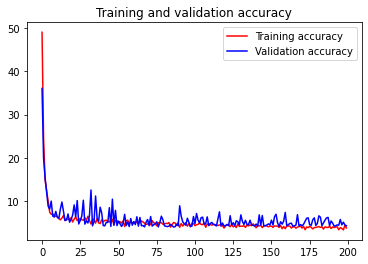

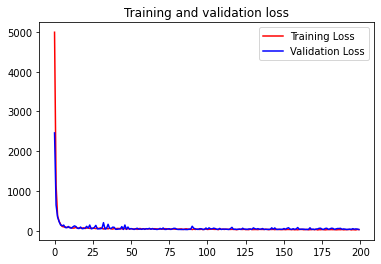

In [187]:
%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['mae']
val_acc = history.history['val_mae']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.savefig('acc.png')

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig('loss.png')
plt.show()